# PORTFOLIO EVALUATOR

Evaluates portfolios, calculates performance metrics, and produces graphs for streamlit app.


In [2]:
# IMPORTS and DISPLAY options
import pandas as pd
from pathlib import Path
import numpy as np
import os, sys, json
import yfinance as yf
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

DATA_DIR = Path.cwd() / "data"

### 1) Importing Data

In [ ]:
# Change this path to your file
PORTFOLIO_CSV = DATA_DIR / "portfolio_weights.csv"  # columns: date, id, weight, stock_ret, 

In [4]:
# Change this path to your file
MKT_CSV = DATA_DIR / "mkt_ind.csv"  # expects columns: year, month, rf, ret


In [5]:
# Load portfolio CSV and prepare columns
def load_portfolio(csv_path: str) -> pd.DataFrame:
    """
    Load a monthly-rebalanced portfolio with columns:
      - date: month-end date (string or datetime)
      - id:   security identifier (string/int)
      - weight: portfolio weight at 'date' (should sum to 1 per month)
      - stock_ret: realized return over NEXT month for that id (aligned so that
                   if date = 2005-01-31, this is Feb return)

    Returns a normalized DataFrame with:
      - date (pd.Timestamp, normalized to month-end)
      - year_month (str, 'YYYY-MM')
      - id (str)
      - weight (float)
      - stock_ret (float or NaN)
    """
    df = pd.read_csv(csv_path)

    required = {"date", "id", "weight", "stock_ret"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    # Parse date and coerce types
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    # Safety: force to period month then back to month-end Timestamp
    df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
    df["year_month"] = df["date"].dt.to_period("M").astype(str)

    # Normalize types
    df["id"] = df["id"].astype(str)
    df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
    df["stock_ret"] = pd.to_numeric(df["stock_ret"], errors="coerce")

    # Sort for consistency
    df = df.sort_values(["date", "id"]).reset_index(drop=True)
    return df

In [6]:
portfolio_df = load_portfolio(PORTFOLIO_CSV)
portfolio_df.head()

,id,date,weight,stock_ret,long_gross,short_gross,year_month
0,comp_002137_01C,2015-02-28,0.008678,-0.022222,0.75058,0.273975,2015-02
1,comp_002408_01C,2015-02-28,0.008741,-0.058103,0.75058,0.273975,2015-02
2,comp_002675_01C,2015-02-28,0.008612,0.009963,0.75058,0.273975,2015-02
3,comp_007770_01C,2015-02-28,-0.002448,-0.087292,0.75058,0.273975,2015-02
4,comp_009215_01C,2015-02-28,0.008546,-0.044078,0.75058,0.273975,2015-02


In [7]:
# Check if valid PF: Validate monthly weight sums

def _is_valid_portfolio(
    portfolio_df: pd.DataFrame,
    *,
    weight_col: str = "weight",
    date_col: str = "year_month",
    net_target: float = 1.0,     # 150/50 => net ≈ +1
    long_cap: float = 1.5,    # sum of longs must be ≤ this
    short_floor: float = -0.5,  # sum of shorts must be ≥ this
    tol: float = 1e-6
):
    """
     Validate monthly sums for a 150/50 mandate with inequality checks:
      - |net_sum - net_target| ≤ tol
      - long_sum ≤ long_cap + tol
      - short_sum ≥ short_floor - tol

    Returns
    -------
    valid : bool
        True if all months meet targets within tolerance.
    invalid_rows : pd.DataFrame
        Rows for months that fail any check, with diagnostics.
    """

    if date_col not in portfolio_df.columns:
        raise KeyError(f"Missing '{date_col}' in portfolio_df")
    if weight_col not in portfolio_df.columns:
        raise KeyError(f"Missing '{weight_col}' in portfolio_df")
    
    # Aggregate by month
    grp = (
        portfolio_df
        .groupby(date_col)
        .agg(
            long_sum=(weight_col, lambda x: x[x > 0].sum()),
            short_sum=(weight_col, lambda x: x[x < 0].sum()),
            net_sum=(weight_col, "sum"),
        )
        .reset_index()
    )
    
    # Per-target checks with tolerance
    pass_net   = (grp["net_sum"] - net_target).abs() <= tol
    pass_long  = grp["long_sum"] <= (long_cap + tol)
    pass_short = grp["short_sum"] >= (short_floor - tol)

    grp["within_targets"] = pass_net & pass_long & pass_short

    # Minimal failure report
    invalid_cols = [date_col, "net_sum", "long_sum", "short_sum", "within_targets"]
    invalid_rows = grp.loc[~grp["within_targets"], invalid_cols].sort_values(by=date_col)

    all_valid = invalid_rows.empty
    return all_valid, invalid_rows

ok, bad = _is_valid_portfolio(portfolio_df)

print("Portfolio valid?", ok)
if not ok:
    print("Invalid months:")
    display(bad)

Portfolio valid? False
Invalid months:


,year_month,net_sum,long_sum,short_sum,within_targets
0,2015-02,0.476605,0.750580,-0.273975,False
1,2015-03,0.633313,0.848620,-0.215306,False
2,2015-04,0.534815,0.775878,-0.241063,False
3,2015-05,0.644423,0.854853,-0.210430,False
4,2015-06,0.624776,0.826405,-0.201629,False
...,...,...,...,...,...
109,2024-03,0.517166,0.667157,-0.149990,False
110,2024-04,1.030019,1.272447,-0.242429,False
111,2024-05,0.828757,1.161956,-0.333199,False
112,2024-06,0.836369,1.082801,-0.246432,False


In [8]:
# Monthly Portfolio Return
def load_prtf_ret(
    port_csv_path: str = PORTFOLIO_CSV,
    *,
    date_col: str = "year_month",
    weight_col: str = "weight",
    ret_col: str = "stock_ret",
    norm: bool = True,
) -> pd.DataFrame:
    """
    Compute the portfolio monthly return at each month-end 'date'.

    Logic:
      - For each month, zero out weights where the realized return is NaN.
      - Re-scale remaining weights within the month to sum to 1 (across valid rows).
      - The month's portfolio return is sum_i w_eff_i * stock_ret_i.

    Returns DataFrame with:
      - year_month (str, 'YYYY-MM')
      - pf_monthly_ret (float)
    """
    df = load_portfolio(port_csv_path)

    monthly_returns = (df.dropna(subset=[ret_col])
                       .groupby(date_col, as_index=False)
                       .apply(lambda g: (g[weight_col] * g[ret_col]).sum(), include_groups=False)
                       .rename(columns={None: "pf_monthly_ret"})
                      )
    
    # Normalized (adjusted to make net-sum = 1)
    if norm:
      monthly_returns = (df.dropna(subset=[ret_col])
                        .groupby(date_col, as_index=False)
                        .apply(lambda g: (g[weight_col] / (g["long_gross"] + g["short_gross"]) * g[ret_col]).sum(), include_groups=False)
                        # .apply(lambda g: (g[weight_col] / g[weight_col].sum() * g[ret_col]).sum(), include_groups=False)
                        .rename(columns={None: "pf_monthly_ret"})
                        )
    
    return monthly_returns


In [9]:
prtf_ret_df = load_prtf_ret()
prtf_ret_df.head()

,year_month,pf_monthly_ret
0,2015-02,0.001788
1,2015-03,0.017001
2,2015-04,-0.004599
3,2015-05,-0.034461
4,2015-06,-0.048392


In [10]:
# Load Market CSV and prepare Monthly Market Return
def load_mkt_ret(
    mkt_csv_path: str = MKT_CSV,
    year_col: str = "year",
    month_col: str = "month",
    mkt_ret_col: str = "ret",
    ticker: str | None = None,  # Optional ticker symbol e.g. "^GSPC" for S&P 500
    start_date: str | None = None,  # "YYYY-MM-DD" format
    end_date: str | None = None,
) -> pd.DataFrame:
    """Load market returns either from CSV or yFinance.
    If ticker is provided, fetches from yFinance. Otherwise loads from CSV."""

    if ticker is not None:
        # Fetch from yFinance
        yf_ticker = yf.Ticker(ticker)
        hist = yf_ticker.history(
            start=start_date,
            end=end_date,
            interval="1mo"
        )
        # Calculate monthly returns
        rm = hist["Close"].pct_change()
        rm.index = pd.PeriodIndex(rm.index.to_period("M"))
        return rm.sort_index()
    
    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, mkt_ret_col):
        if c not in mk.columns:
            raise KeyError(
                f"CSV must contain '{year_col}', '{month_col}', and '{mkt_ret_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    rm = (
        mk[["year_month", mkt_ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[mkt_ret_col]
        .astype(float)
        .sort_index()
    )
    return rm

In [11]:
mkt_ret_df = load_mkt_ret()
mkt_ret_df.head()

year_month
2005-01   -0.025290
2005-02    0.018903
2005-03   -0.019118
2005-04   -0.020109
2005-05    0.029952
Freq: M, Name: ret, dtype: float64

In [12]:
sp500_ret = load_mkt_ret(
    ticker="^GSPC",
    start_date="2014-01-01",
    end_date="2023-12-31"
)
sp500_ret.head()

C:\Users\erikh\AppData\Local\Temp\ipykernel_21008\1830192825.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  rm.index = pd.PeriodIndex(rm.index.to_period("M"))


Date
2014-01         NaN
2014-02    0.043117
2014-03    0.006932
2014-04    0.006201
2014-05    0.021030
Freq: M, Name: Close, dtype: float64

In [13]:
# Load Market CSV and prepare Monthly Riskless Return
def load_rf_ret(
    mkt_csv_path: str = MKT_CSV,
    rf_col: str = "rf",
    year_col: str = "year",
    month_col: str = "month",
) -> pd.DataFrame:
    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, rf_col):
        if c not in mk.columns:
            raise KeyError(
                f"CSV must contain '{year_col}', '{month_col}', and '{rf_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
        
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    
    rf = (
        mk[["year_month", rf_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[rf_col]
        .astype(float)
        .sort_index()
    )
    return rf

In [14]:
rf_ret_df = load_rf_ret()
rf_ret_df.head()

year_month
2005-01    0.0016
2005-02    0.0016
2005-03    0.0021
2005-04    0.0021
2005-05    0.0024
Freq: M, Name: rf, dtype: float64

### 2) Evaluation Functions:
THERE ARE SOME ISSUES WITH THE MONTHLY RETURN VALUES FOR PORTFOLIO

In [15]:
# Risk / Return Helpers (annualized where relevant)
def cagr() -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()
    
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return np.nan
    
    total_growth = (1.0 + r).prod()
    years = len(r) / 12.0
    if years <= 0:
        return np.nan
    
    return float(total_growth ** (1.0 / years) - 1.0)

def std() -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.size == 0:
        return np.nan
    
    std_m = r.std(ddof=1)
    if np.isnan(std_m):
        return np.nan
    
    return float(std_m * np.sqrt(12.0))

def sharpe_ratio(
    ret_rf: pd.DataFrame,
    annualize: bool = True,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    r_idx = pd.PeriodIndex(m["year_month"], freq="M")
    r = pd.Series(r.values, index=r_idx).dropna().sort_index()
    if r.size < 2:
        return np.nan

    rf = ret_rf

    # Excess returns aligned
    common = r.index.intersection(rf.index)
    if len(common) < 2:
        return np.nan
    ex = (r.loc[common] - rf.loc[common]).dropna()
    if ex.size < 2:
        return np.nan

    mu_m = ex.mean()
    sd_m = ex.std(ddof=1)
    if sd_m == 0 or np.isnan(sd_m):
        return np.nan

    sr = mu_m / sd_m
    return float(sr * np.sqrt(12.0)) if annualize else float(sr)

def active_alpha(
    ret_mkt: pd.DataFrame,
    annualize: bool = True,   
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.empty:
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan

    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.empty:
        return np.nan
    return float(active.mean() * 12.0) if annualize else float(active.mean())
    

def tracking_error(
    ret_mkt: pd.DataFrame,
    annualize: bool = True,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.empty:
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan

    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.empty:
        return np.nan

    te_m = active.std(ddof=1)
    return float(te_m * np.sqrt(12.0)) if annualize else float(te_m)



def information_ratio(
    ret_mkt: pd.DataFrame,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.size < 2:
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan
    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.size < 2:
        return np.nan

    te_ann = tracking_error(ret_mkt, annualize=True)

    if te_ann is None or np.isnan(te_ann) or te_ann == 0:
        return np.nan

    mu_active_ann = float(active.mean() * 12.0)
    return mu_active_ann / te_ann


In [16]:
# Drawdown, Turnover, and Summary Stats
def drawdown_series() -> pd.Series:
    
    # Portfolio monthly returns
    m = load_prtf_ret()
    
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return pd.Series(dtype=float, name="drawdown")

    idx = pd.PeriodIndex(m.loc[r.index, "year_month"], freq="M")
    r = pd.Series(r.values, index=idx).sort_index()

    cum = (1.0 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0

    dd = dd.copy()
    dd.index = dd.index.astype(str)
    dd.name = "drawdown"
    return dd

def turnover(
    id_col: str = "id",
    ym_col: str = "year_month",
    weight_col: str = "weight",
    symmetric: bool = False,
) -> pd.DataFrame:
    
    df = load_portfolio(PORTFOLIO_CSV)
    if ym_col not in df.columns:
        if "date" not in df.columns:
            raise KeyError(f"Need '{ym_col}' or 'date' in portfolio_df.")
        df[ym_col] = pd.to_datetime(df["date"]).dt.to_period("M").astype(str)

    df = df[[id_col, ym_col, weight_col]].dropna(subset=[ym_col])
    held = (
        df[df[weight_col] > 0]
        .groupby(ym_col)[id_col]
        .apply(lambda s: set(s.astype(str)))
        .sort_index()
    )

    results = []
    prev_set = None
    for ym, curr_set in held.items():
        if prev_set is None:
            prev_set = curr_set
            continue
        denom = len(prev_set | curr_set) if symmetric else len(prev_set)
        denom = max(1, denom)
        overlap = len(prev_set & curr_set)
        turn = 1.0 - (overlap / denom)
        results.append((ym, turn))
        prev_set = curr_set

    return pd.DataFrame(results, columns=[ym_col, "turnover"])

def summary_statistics(
    ret_mkt: pd.DataFrame,
    ret_rf: pd.DataFrame,
) -> pd.DataFrame:
    m = load_prtf_ret()
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()

    max_one_m_loss = float(r.min()) if not r.empty else np.nan
    dd = drawdown_series()
    max_drawdown = float(dd.min()) if dd.size else np.nan
    to_df = turnover()
    avg_turnover = float(to_df["turnover"].mean()) if not to_df.empty else np.nan

    cagr_val   = cagr()
    std_val    = std()
    sharpe_val = sharpe_ratio(ret_rf)
    alpha_val  = active_alpha(ret_mkt)
    ir_val     = information_ratio(ret_mkt)

    stats = pd.DataFrame(
        {
            "metric": [
                "CAGR",
                "STD",
                "Sharpe",
                "IR",
                "Alpha",
                "Max Drawdown",
                "Max_one_month_loss",
                "Avg_Turnover",
            ],
            "value": [
                cagr_val,
                std_val,
                sharpe_val,
                ir_val,
                alpha_val,
                max_drawdown,
                max_one_m_loss,
                avg_turnover,
            ],
        }
    )
    return stats


### 3) Calculate Results

In [17]:
# Set Parameters:
mkt_ret = load_mkt_ret(
    ticker="^GSPC",
    start_date="2014-01-01",
    end_date="2023-12-31"
)

rf_ret = load_rf_ret()

C:\Users\erikh\AppData\Local\Temp\ipykernel_21008\1830192825.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  rm.index = pd.PeriodIndex(rm.index.to_period("M"))


In [18]:
# Calculate Stats
stats = summary_statistics(mkt_ret, rf_ret)
stats


,metric,value
0,CAGR,0.048277
1,STD,0.098162
2,Sharpe,0.373469
3,IR,-0.370818
4,Alpha,-0.067853
5,Max Drawdown,-0.192463
6,Max_one_month_loss,-0.142340
7,Avg_Turnover,0.520271


### 4) Export Data / Results

In [19]:
# EXPORT PORTFOLIO RETURNS
portfolio_file = "outputs/prtf_ret.csv"

# Standardize Naming
prtf_df = prtf_ret_df.rename(columns={"year_month": "date", "pf_monthly_ret": "ret"}).copy()

prtf_df.to_csv(portfolio_file, index=False)

In [ ]:
# EXPORT MARKET RETURNS
market_file = "outputs/mkt_ret.csv"

# Match market returns timeframe to portfolio returns
start_date = prtf_df["date"].min()
end_date = prtf_df["date"].max()

# Filter market returns to start from 2015-01 and rename 
mkt_df = (mkt_ret_df
          .loc[start_date:end_date]
          .copy()
          .reset_index()
          .rename(columns={"year_month": "date"})
)

mkt_df.to_csv(market_file, index=False)

In [21]:
# Turn table into Json
stats_dict = {
    row["metric"]: row["value"]
    for _, row in stats.iterrows()
}

main_file = "outputs/metrics.json"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_file = f"outputs/backups/t_metrics_{timestamp}.json"

with open(main_file, "w") as f:
    json.dump(stats_dict, f, indent=4)

print(f"✅ Latest metrics saved to {main_file}")

shutil.copy(main_file, backup_file)

print(f"🗂️ Backup created: {backup_file}")

stats_dict

✅ Latest metrics saved to outputs/metrics.json
🗂️ Backup created: outputs/backups/t_metrics_20251103_130448.json


{'CAGR': 0.04827717153170297,
 'STD': 0.09816210643585244,
 'Sharpe': 0.37346915326210706,
 'IR': -0.37081766848814285,
 'Alpha': -0.06785272243651912,
 'Max Drawdown': -0.19246331315649534,
 'Max_one_month_loss': -0.14234038886586164,
 'Avg_Turnover': 0.520270699028781}

In [34]:
# ---------- THEME ----------
BRAND = {
    "bg": "white",
    "fg": "#003366",        # deep navy for text/axes
    "grid": "#cce0ff",      # very light blue for gridlines

    # Line colors
    "portfolio": "#e64f3c",       # strong orange/red
    "market":    "#007acc",       # bright blue

    # Fill colors (lighter accents)
    "drawdown_fill_pf": "#f28c3c",   # lighter orange
    "drawdown_fill_mkt": "#66a3ff",  # light blue
}


plt.rcParams.update({
    "figure.figsize": (10, 4.5),
    "figure.facecolor": BRAND["bg"],
    "axes.facecolor": BRAND["bg"],
    "axes.edgecolor": BRAND["fg"],
    "axes.labelcolor": BRAND["fg"],
    "axes.titlecolor": BRAND["fg"],
    "xtick.color": BRAND["fg"],
    "ytick.color": BRAND["fg"],
    "grid.color": BRAND["grid"],
    "grid.linestyle": "-",
    "grid.alpha": 0.6,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlepad": 10,
    "axes.titleweight": "semibold",
    "legend.frameon": False,
    "legend.fontsize": 11,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

def _nicely_format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(6,)))
    ax.grid(True, which="major")
    ax.grid(True, which="minor", axis="x", alpha=0.15)

def _end_label(ax, x, y, label, color, offset=5):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(offset, 0),
        textcoords="offset points",
        va="center",
        ha="left",
        fontsize=11,
        color=color,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.85),
    )

def _to_ts_index(r_period_idx: pd.PeriodIndex) -> pd.DatetimeIndex:
    return r_period_idx.to_timestamp("M")

# ---------- LOAD MARKET RETURNS ----------
def load_market_returns(
    mkt_csv_path: str,
    year_col: str = "year",
    month_col: str = "month",
    ret_col: str = "ret",
) -> pd.Series:
    mk = pd.read_csv(mkt_csv_path)
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int), month=mk[month_col].astype(int), freq="M"
    )
    r_mkt = (
        mk[["year_month", ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[ret_col]
        .astype(float)
        .sort_index()
    )
    return r_mkt

# ---------- PLOTTING: CUMULATIVE ----------

def plot_cumulative_pretty(
    r_pf: pd.Series,             # monthly portfolio returns (PeriodIndex 'M')
    r_mkt: pd.Series,            # monthly market returns   (PeriodIndex 'M')
    *,
    start: float=100,
    title: str = "Cumulative Return (Monthly, %)",
    save_path: str | None = None
):
    
    # # align and sort
    # common = r_pf.index.intersection(r_mkt.index)
    # rpf, rmk = r_pf.loc[common].sort_index(), r_mkt.loc[common].sort_index()

    # # compound to wealth
    # w_pf  = start * (1 + rpf.fillna(0)).cumprod()
    # w_mkt = start * (1 + rmk.fillna(0)).cumprod()
    
    # w_pf.index  = w_pf.index.to_timestamp(how="end")   # if PeriodIndex
    # w_mkt.index = w_mkt.index.to_timestamp(how="end")

    # fig, ax = plt.subplots()
    # ax.plot(w_pf, linewidth=2.2, label="Portfolio")
    # ax.plot(w_mkt, linewidth=2.2, label="S&P500")
    # ax.set_title(title)
    # ax.set_ylabel("Value (start=100)")
    # ax.set_xlabel("Date")
    # ax.legend(loc="upper left")
    # plt.tight_layout()
    # plt.show()
    
    # align
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    # cumulative growth → convert to cumulative wealth
    cum_pf  = (1 + rpf).cumprod() - 1
    cum_mkt = (1 + rmk).cumprod() - 1

    idx_ts = _to_ts_index(common)
    cum_pf.index, cum_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots()
    l1, = ax.plot(cum_pf, color=BRAND["portfolio"], linewidth=2.4, label="Portfolio")
    l2, = ax.plot(cum_mkt, color=BRAND["market"], linewidth=2.4, label="S&P500")

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Cumulative Return (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [0,1] → show as %

    # end labels as percentages
    _end_label(ax, cum_pf.index[-1], cum_pf.iloc[-1],
               f"{cum_pf.iloc[-1]*100:.1f}%", BRAND["portfolio"])
    _end_label(ax, cum_mkt.index[-1], cum_mkt.iloc[-1],
               f"{cum_mkt.iloc[-1]*100:.1f}%", BRAND["market"])

    ax.legend(loc="upper left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# ---------- PLOTTING: DRAWDOWN ----------
def plot_drawdown_pretty(
    r_pf: pd.Series,
    r_mkt: pd.Series,
    *,
    title: str = "Drawdown (Monthly)",
    save_path: str | None = None
):
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    def dd_from_r(r: pd.Series) -> pd.Series:
        cg = (1 + r).cumprod()
        peak = cg.cummax()
        return cg / peak - 1.0

    dd_pf  = dd_from_r(rpf)
    dd_mkt = dd_from_r(rmk)

    idx_ts = _to_ts_index(common)
    dd_pf.index, dd_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots(figsize=(10, 3.8))
    # filled areas for punchier visuals
    ax.fill_between(dd_pf.index, dd_pf, 0, color=BRAND["drawdown_fill_pf"], alpha=0.18, label="Portfolio")
    ax.plot(dd_pf, color=BRAND["portfolio"], linewidth=2.0)
    ax.fill_between(dd_mkt.index, dd_mkt, 0, color=BRAND["drawdown_fill_mkt"], alpha=0.14, label="S&P 500")
    ax.plot(dd_mkt, color=BRAND["market"], linewidth=2.0)

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Drawdown (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [-1, 0]
    ax.legend(loc="lower left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


C:\Users\erikh\AppData\Local\Temp\ipykernel_21008\1830192825.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  rm.index = pd.PeriodIndex(rm.index.to_period("M"))


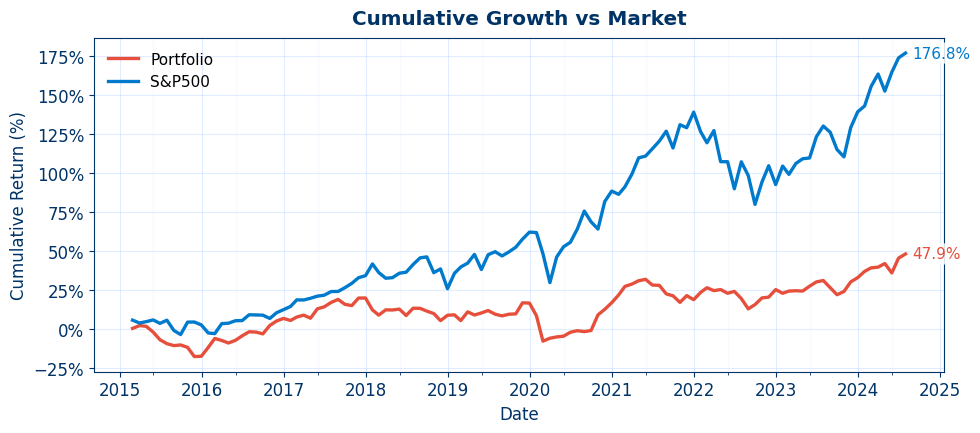

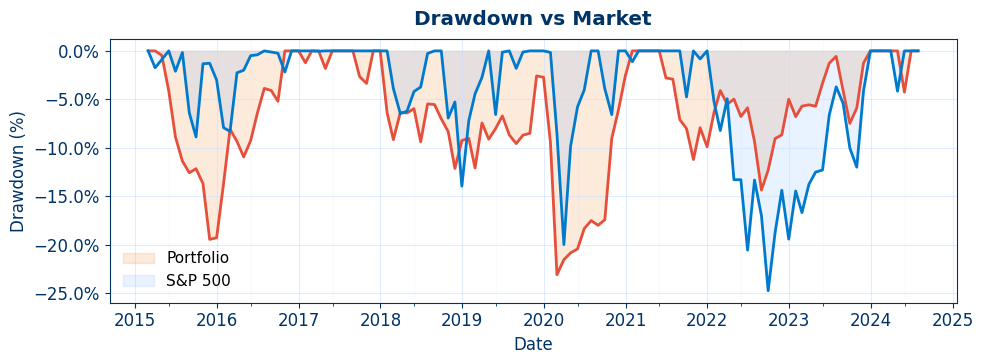

In [36]:
m = load_prtf_ret(norm=False)
r_pf = pd.Series(
    pd.to_numeric(m["pf_monthly_ret"], errors="coerce").values,
    index=pd.PeriodIndex(m["year_month"], freq="M"),
).dropna().sort_index()

r_mkt = load_mkt_ret(
    ticker="^GSPC",
    start_date="2014-01-01",
    end_date="2024-12-31"
)

plot_cumulative_pretty(r_pf, r_mkt, title="Cumulative Growth vs Market")
plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs Market")

# Save high-DPI images for slides:
#plot_cumulative_pretty(r_pf, r_mkt, title="Portfolio vs S&P500", save_path="cum_indexed.png")
#plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs S&P500", save_path="drawdown.png")
